# Predicción de usuarios

Aqui intentamos predecir a que candidato sigue una persona de acuerdo a su vector de topicos

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import coo_matrix

import sklearn.metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
TOPICOS_RETWEETS_PRIMERA_VUELTA = sp.load_npz('data/06_TOPICOS_RETWEETS_primera_vuelta.npz')
Y_TOPICOS_RETWEETS_PRIMERA_VUELTA = np.load('data/06_Y_RETWEETS_primera_vuelta.npy')

LDA_RETWEETS_PRIMERA_VUELTA = np.load('data/06_LDA_RETWEETS_primera_vuelta.npy')
Y_LDA_RETWEETS_PRIMERA_VUELTA = np.load('data/06_Y_RETWEETS_primera_vuelta.npy')

TOPICOS_RETWEETS_TODO_PERIODO = sp.load_npz('data/06_TOPICOS_RETWEETS.npz')
Y_TOPICOS_RETWEETS_TODO_PERIODO = np.load('data/06_Y_RETWEETS.npy')

LDA_RETWEETS_TODO_PERIODO = np.load('data/06_LDA_RETWEETS.npy')
Y_LDA_RETWEETS_TODO_PERIODO = np.load('data/06_Y_RETWEETS.npy')

In [3]:
tfidf_transformer = TfidfTransformer()
TOPICOS_RETWEETS_PRIMERA_VUELTA = tfidf_transformer.fit_transform(TOPICOS_RETWEETS_PRIMERA_VUELTA)
TOPICOS_RETWEETS_PRIMERA_VUELTA

<21883x136 sparse matrix of type '<class 'numpy.float64'>'
	with 141150 stored elements in Compressed Sparse Row format>

In [4]:
LDA_RETWEETS_PRIMERA_VUELTA.shape

(21883, 136)

In [5]:
tfidf_transformer = TfidfTransformer()
TOPICOS_RETWEETS_TODO_PERIODO = tfidf_transformer.fit_transform(TOPICOS_RETWEETS_TODO_PERIODO)
TOPICOS_RETWEETS_TODO_PERIODO

<52720x124 sparse matrix of type '<class 'numpy.float64'>'
	with 424101 stored elements in Compressed Sparse Row format>

In [6]:
LDA_RETWEETS_TODO_PERIODO.shape

(52720, 124)

In [7]:
def evaluar_clasificador(clf, X, Y, 
        cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=['accuracy', 'balanced_accuracy']):
    """Funcion que evalua un clasificador utilizando por defecto una division del
    set de train y test de acuerdo a la cantidad de seguidores politicos que hay
    y con metricas de cuanto se esta prediciendo correctamente a todos, y ponderada por clase"""
    if (isinstance(scoring, str)):
        scores = cross_val_score(clf, X, Y, cv=cv, scoring=scoring)
        print("Balanced accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
    else:
        scores = cross_validate(clf, X, Y, cv=cv, scoring=scoring)
        for k in scores.keys():
            if (k.startswith('test_')):
                print(k + ": %0.2f (+/- %0.2f)" % (scores[k].mean(), scores[k].std()*2))

In [8]:
def plot_confusion_matrix(y_true, y_pred, title, normalize=True, cmap=plt.cm.Blues):
    """Funcion copiada de la documentacion de matplotlib para hacer una matriz de confusion"""
    plt.rcParams.update({'font.size': 24})
    plt.rcParams['figure.figsize'] = [15, 10]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.array(['Macri', 'Scioli', 'Massa', 'Stolbizer'])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Clase verdadera',
           xlabel='Clase predicha')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.plot()

def matriz_confusion(clf, X, Y, title, cv=StratifiedKFold(n_splits=5, shuffle=True)):
    y_pred = cross_val_predict(clf, X, Y, cv=StratifiedKFold(n_splits=5, shuffle=True))
    plot_confusion_matrix(Y, y_pred, title)

# Resultados de clasificación

In [9]:
evaluar_clasificador(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = 1000, min_samples_leaf=1, min_samples_split=2, n_estimators=1000,
    ), TOPICOS_RETWEETS_PRIMERA_VUELTA, Y_TOPICOS_RETWEETS_PRIMERA_VUELTA)

test_accuracy: 0.84 (+/- 0.01)
test_balanced_accuracy: 0.77 (+/- 0.01)


In [10]:
evaluar_clasificador(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = None, min_samples_leaf=1, min_samples_split=15, n_estimators=1000,
    ), LDA_RETWEETS_PRIMERA_VUELTA, Y_LDA_RETWEETS_PRIMERA_VUELTA)

test_accuracy: 0.85 (+/- 0.01)
test_balanced_accuracy: 0.78 (+/- 0.02)


In [11]:
evaluar_clasificador(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = 1000, min_samples_leaf=1, min_samples_split=2, n_estimators=1000,
    ), TOPICOS_RETWEETS_TODO_PERIODO, Y_TOPICOS_RETWEETS_TODO_PERIODO)

test_accuracy: 0.84 (+/- 0.00)
test_balanced_accuracy: 0.67 (+/- 0.01)


In [12]:
evaluar_clasificador(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = None, min_samples_leaf=1, min_samples_split=15, n_estimators=1000,
    ), LDA_RETWEETS_TODO_PERIODO, Y_LDA_RETWEETS_TODO_PERIODO)

test_accuracy: 0.84 (+/- 0.00)
test_balanced_accuracy: 0.66 (+/- 0.01)


## Matrices de confusión

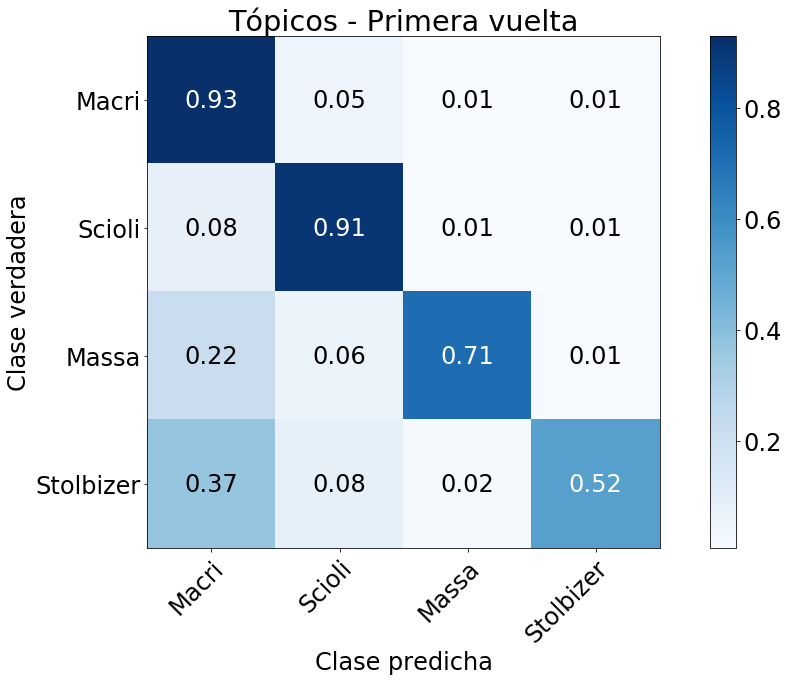

In [13]:
matriz_confusion(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = 1000, min_samples_leaf=1, min_samples_split=2, n_estimators=1000,
    ), TOPICOS_RETWEETS_PRIMERA_VUELTA, Y_TOPICOS_RETWEETS_PRIMERA_VUELTA, 'Tópicos - Primera vuelta')

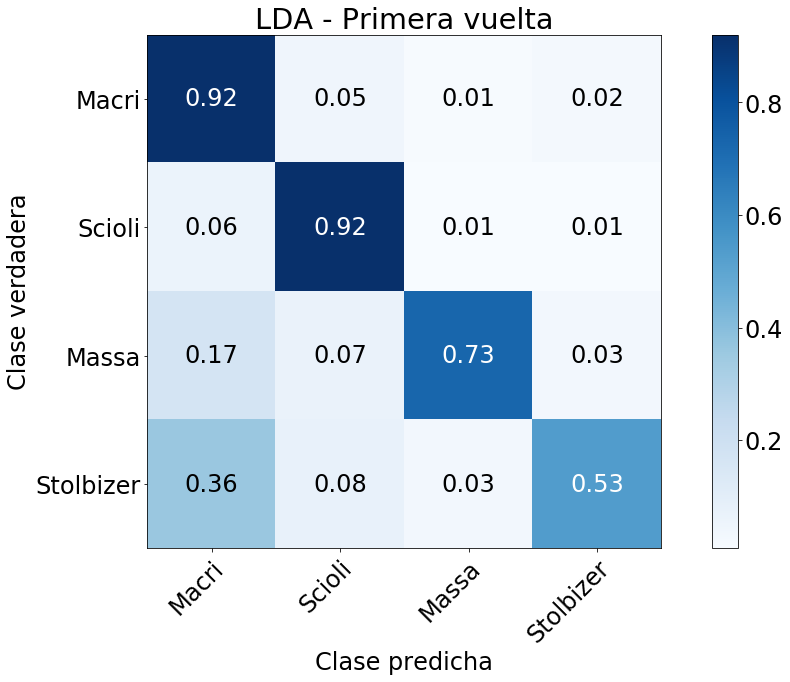

In [14]:
matriz_confusion(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = None, min_samples_leaf=1, min_samples_split=15, n_estimators=1000,
    ), LDA_RETWEETS_PRIMERA_VUELTA, Y_LDA_RETWEETS_PRIMERA_VUELTA, 'LDA - Primera vuelta')

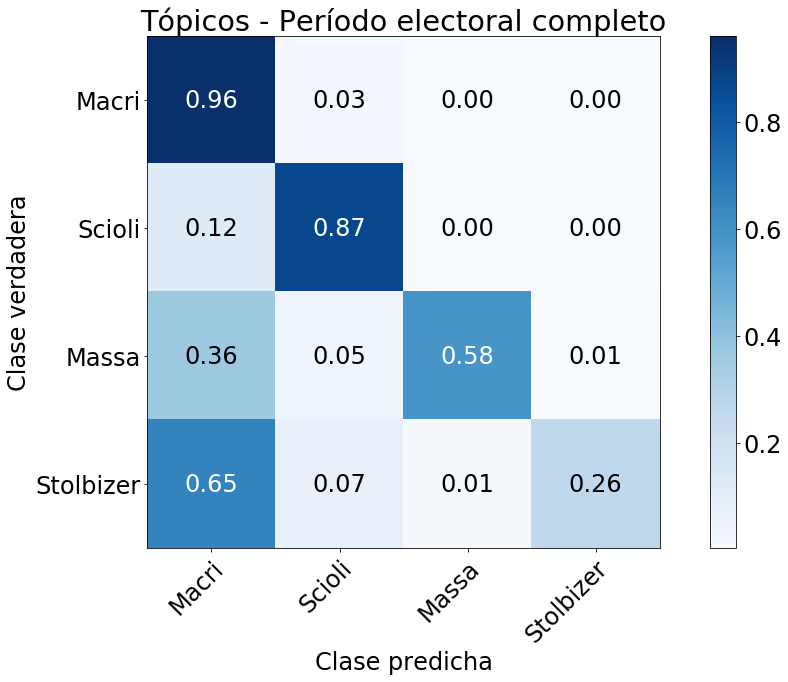

In [15]:
matriz_confusion(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = 1000, min_samples_leaf=1, min_samples_split=2, n_estimators=1000,
    ), TOPICOS_RETWEETS_TODO_PERIODO, Y_TOPICOS_RETWEETS_TODO_PERIODO, 'Tópicos - Período electoral completo')

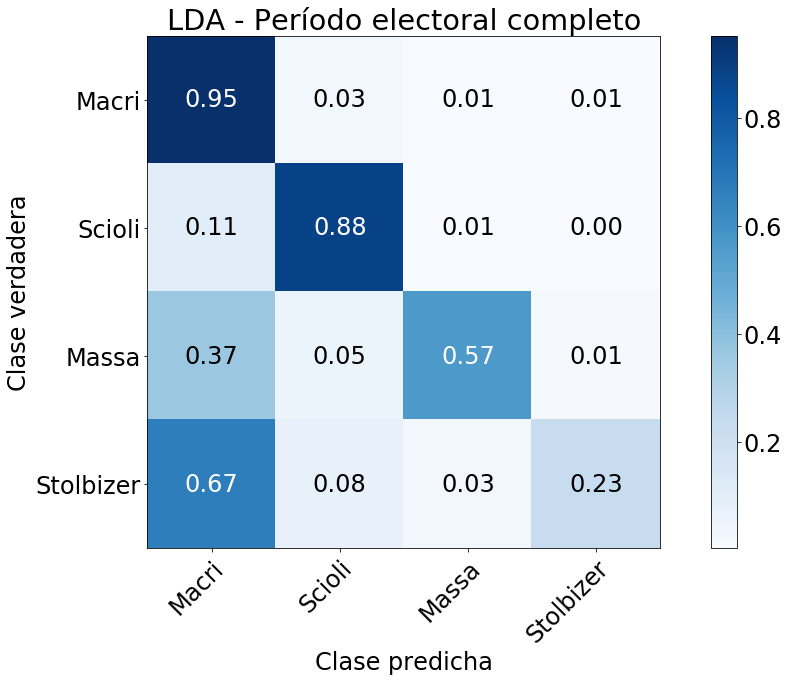

In [16]:
matriz_confusion(RandomForestClassifier(max_depth=None,
    max_features=10, max_leaf_nodes = None, min_samples_leaf=1, min_samples_split=15, n_estimators=1000,
    ), LDA_RETWEETS_TODO_PERIODO, Y_LDA_RETWEETS_TODO_PERIODO, 'LDA - Período electoral completo')